In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shutil
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [6]:
# Define paths
RAW_DATA_PATH = '/content/drive/MyDrive/brain-tumor-classification/data/raw'
PROCESSED_DATA_PATH = '/content/drive/MyDrive/brain-tumor-classification/data/processed'

# Configuration
IMG_SIZE = 224  # Standard size for VGG16, ResNet50, EfficientNetB0, MobileNetV2
TUMOR_CLASSES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

print(f"Raw Data Path: {RAW_DATA_PATH}")
print(f"Processed Data Path: {PROCESSED_DATA_PATH}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Classes: {TUMOR_CLASSES}")

Raw Data Path: /content/drive/MyDrive/brain-tumor-classification/data/raw
Processed Data Path: /content/drive/MyDrive/brain-tumor-classification/data/processed
Image Size: 224x224
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [7]:
# Check if raw data path exists
if not os.path.exists(RAW_DATA_PATH):
    print(f"Error: Raw data path does not exist: {RAW_DATA_PATH}")
else:
    print("Raw data path exists!")

# Explore the structure
print("\n" + "="*50)
print("Dataset Structure:")
print("="*50)

for split in ['Training', 'Testing']:
    split_path = os.path.join(RAW_DATA_PATH, split)
    if os.path.exists(split_path):
        print(f"\n{split} folder:")
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  - {class_name}: {num_images} images")
    else:
        print(f"\n{split} folder does not exist!")

Raw data path exists!

Dataset Structure:

Training folder:
  - pituitary_tumor: 827 images
  - glioma_tumor: 826 images
  - no_tumor: 395 images
  - meningioma_tumor: 822 images

Testing folder:
  - glioma_tumor: 100 images
  - pituitary_tumor: 74 images
  - meningioma_tumor: 115 images
  - no_tumor: 105 images


In [8]:
# Create processed data directory structure
def create_processed_structure():
    """Create folder structure for processed data"""

    # Create main processed directory
    os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

    # Create Training and Testing folders
    for split in ['Training', 'Testing']:
        split_path = os.path.join(PROCESSED_DATA_PATH, split)
        os.makedirs(split_path, exist_ok=True)

        # Create class folders
        for class_name in TUMOR_CLASSES:
            class_path = os.path.join(split_path, class_name)
            os.makedirs(class_path, exist_ok=True)

    print("Processed folder structure created successfully!")
    print(f"\nStructure created at: {PROCESSED_DATA_PATH}")

create_processed_structure()

Processed folder structure created successfully!

Structure created at: /content/drive/MyDrive/brain-tumor-classification/data/processed


In [9]:
def preprocess_image(image_path, target_size=IMG_SIZE):
    """
    Preprocess a single image:
    1. Read image
    2. Resize to target size
    3. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    4. Normalize
    5. Denoise (optional)
    """
    try:
        # Read image
        img = cv2.imread(image_path)

        if img is None:
            print(f"Warning: Could not read image {image_path}")
            return None

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img_resized = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

        # Convert to grayscale for CLAHE
        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_gray = clahe.apply(gray)

        # Convert back to RGB
        enhanced_rgb = cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2RGB)

        # Apply slight Gaussian blur to reduce noise
        denoised = cv2.GaussianBlur(enhanced_rgb, (3, 3), 0)

        return denoised

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None


def check_image_quality(image_path):
    """
    Check if image is valid and not corrupted
    """
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is an image
        return True
    except:
        return False

In [10]:
def process_and_save_dataset():
    """
    Process all images from raw dataset and save to processed folder
    """

    statistics = {
        'Training': {},
        'Testing': {}
    }

    corrupted_images = []

    # Process both Training and Testing splits
    for split in ['Training', 'Testing']:
        print(f"\n{'='*60}")
        print(f"Processing {split} Data")
        print(f"{'='*60}\n")

        raw_split_path = os.path.join(RAW_DATA_PATH, split)
        processed_split_path = os.path.join(PROCESSED_DATA_PATH, split)

        if not os.path.exists(raw_split_path):
            print(f"Warning: {split} folder not found in raw data!")
            continue

        statistics[split] = {}

        # Process each class
        for class_name in TUMOR_CLASSES:
            raw_class_path = os.path.join(raw_split_path, class_name)
            processed_class_path = os.path.join(processed_split_path, class_name)

            if not os.path.exists(raw_class_path):
                print(f"Warning: Class folder {class_name} not found in {split}!")
                continue

            # Get all image files
            image_files = [f for f in os.listdir(raw_class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

            print(f"Processing {class_name}: {len(image_files)} images")

            processed_count = 0
            failed_count = 0

            # Process each image with progress bar
            for img_file in tqdm(image_files, desc=f"  {class_name}"):
                raw_img_path = os.path.join(raw_class_path, img_file)
                processed_img_path = os.path.join(processed_class_path, img_file)

                # Check image quality
                if not check_image_quality(raw_img_path):
                    corrupted_images.append(raw_img_path)
                    failed_count += 1
                    continue

                # Preprocess image
                processed_img = preprocess_image(raw_img_path, IMG_SIZE)

                if processed_img is not None:
                    # Save processed image
                    processed_img_bgr = cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(processed_img_path, processed_img_bgr)
                    processed_count += 1
                else:
                    failed_count += 1

            statistics[split][class_name] = {
                'total': len(image_files),
                'processed': processed_count,
                'failed': failed_count
            }

            print(f"  ✓ Processed: {processed_count}/{len(image_files)}")
            if failed_count > 0:
                print(f"  ✗ Failed: {failed_count}")

    return statistics, corrupted_images

# Run preprocessing
print("Starting preprocessing...")
stats, corrupted = process_and_save_dataset()
print("\n" + "="*60)
print("Preprocessing Complete!")
print("="*60)

Starting preprocessing...

Processing Training Data

Processing glioma_tumor: 826 images


  glioma_tumor: 100%|██████████| 826/826 [00:42<00:00, 19.48it/s]


  ✓ Processed: 826/826
Processing meningioma_tumor: 822 images


  meningioma_tumor: 100%|██████████| 822/822 [00:46<00:00, 17.77it/s]


  ✓ Processed: 822/822
Processing no_tumor: 395 images


  no_tumor: 100%|██████████| 395/395 [00:16<00:00, 24.68it/s]


  ✓ Processed: 395/395
Processing pituitary_tumor: 827 images


  pituitary_tumor: 100%|██████████| 827/827 [00:48<00:00, 17.07it/s]


  ✓ Processed: 827/827

Processing Testing Data

Processing glioma_tumor: 100 images


  glioma_tumor: 100%|██████████| 100/100 [00:04<00:00, 24.09it/s]


  ✓ Processed: 100/100
Processing meningioma_tumor: 115 images


  meningioma_tumor: 100%|██████████| 115/115 [00:04<00:00, 28.08it/s]


  ✓ Processed: 115/115
Processing no_tumor: 105 images


  no_tumor: 100%|██████████| 105/105 [00:04<00:00, 24.46it/s]


  ✓ Processed: 105/105
Processing pituitary_tumor: 74 images


  pituitary_tumor: 100%|██████████| 74/74 [00:14<00:00,  5.10it/s]

  ✓ Processed: 74/74

Preprocessing Complete!


In [11]:
# Display detailed statistics
print("\n" + "="*60)
print("PREPROCESSING STATISTICS")
print("="*60)

for split in ['Training', 'Testing']:
    if split in stats and stats[split]:
        print(f"\n{split} Set:")
        print("-" * 60)

        total_images = 0
        total_processed = 0
        total_failed = 0

        for class_name, class_stats in stats[split].items():
            print(f"\n  {class_name}:")
            print(f"    Total images:     {class_stats['total']}")
            print(f"    Processed:        {class_stats['processed']}")
            print(f"    Failed:           {class_stats['failed']}")

            total_images += class_stats['total']
            total_processed += class_stats['processed']
            total_failed += class_stats['failed']

        print(f"\n  {split} Total:")
        print(f"    Total images:     {total_images}")
        print(f"    Processed:        {total_processed}")
        print(f"    Failed:           {total_failed}")
        print(f"    Success Rate:     {(total_processed/total_images*100):.2f}%")

# Display corrupted images if any
if corrupted:
    print(f"\n\n{'='*60}")
    print(f"WARNING: {len(corrupted)} Corrupted Images Found")
    print("="*60)
    for img_path in corrupted[:10]:  # Show first 10
        print(f"  - {img_path}")
    if len(corrupted) > 10:
        print(f"  ... and {len(corrupted) - 10} more")


PREPROCESSING STATISTICS

Training Set:
------------------------------------------------------------

  glioma_tumor:
    Total images:     826
    Processed:        826
    Failed:           0

  meningioma_tumor:
    Total images:     822
    Processed:        822
    Failed:           0

  no_tumor:
    Total images:     395
    Processed:        395
    Failed:           0

  pituitary_tumor:
    Total images:     827
    Processed:        827
    Failed:           0

  Training Total:
    Total images:     2870
    Processed:        2870
    Failed:           0
    Success Rate:     100.00%

Testing Set:
------------------------------------------------------------

  glioma_tumor:
    Total images:     100
    Processed:        100
    Failed:           0

  meningioma_tumor:
    Total images:     115
    Processed:        115
    Failed:           0

  no_tumor:
    Total images:     105
    Processed:        105
    Failed:           0

  pituitary_tumor:
    Total images:     

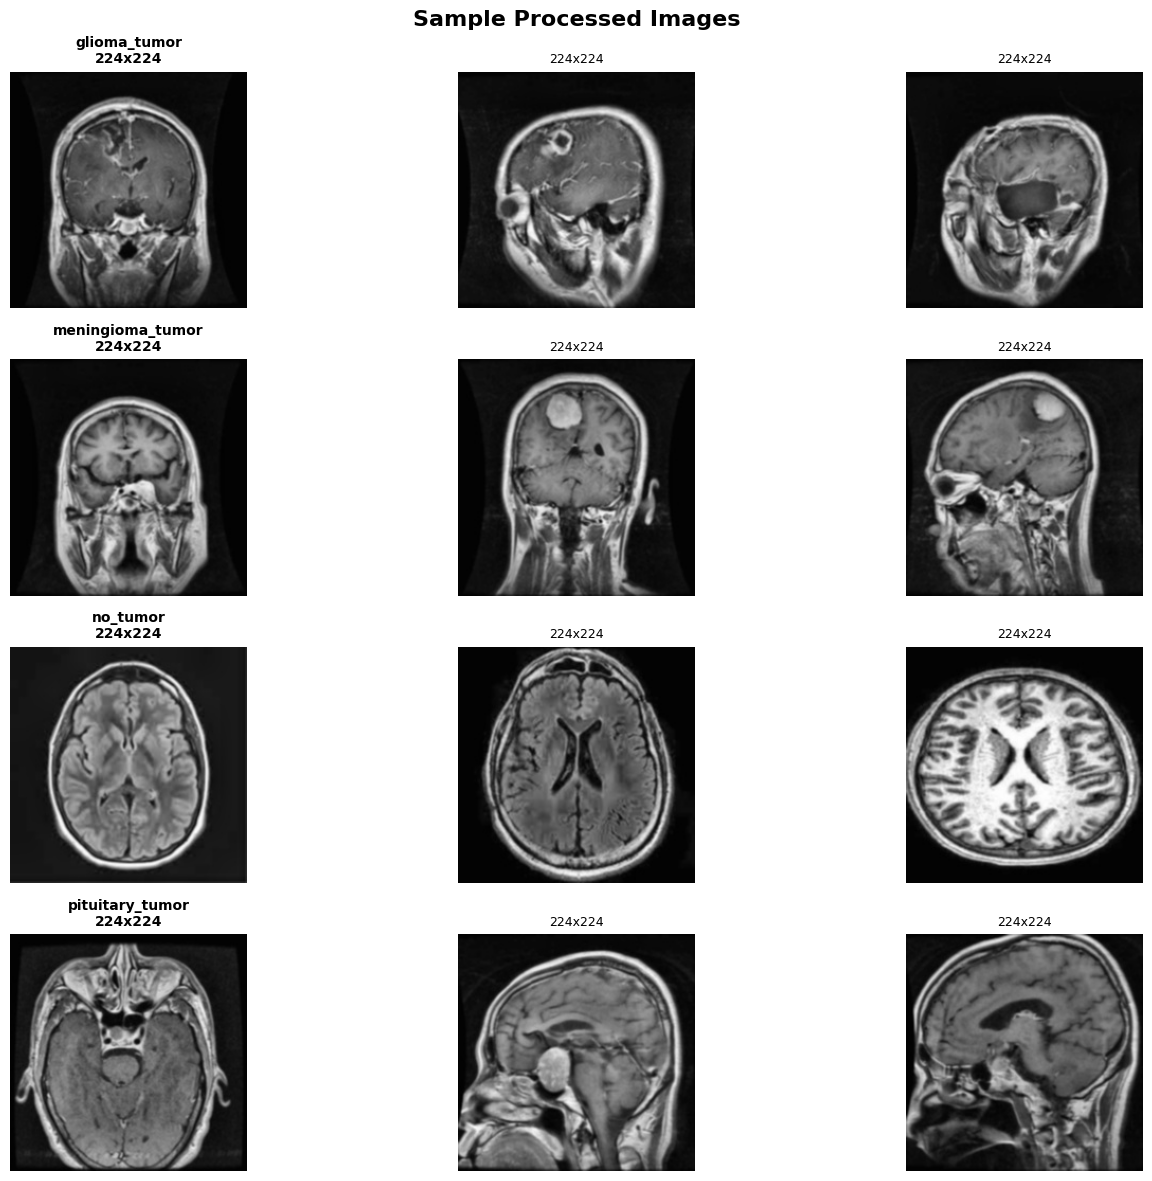

In [12]:
def visualize_processed_samples(num_samples=3):
    """
    Visualize sample processed images from each class
    """
    fig, axes = plt.subplots(len(TUMOR_CLASSES), num_samples, figsize=(15, 12))
    fig.suptitle('Sample Processed Images', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(TUMOR_CLASSES):
        processed_class_path = os.path.join(PROCESSED_DATA_PATH, 'Training', class_name)

        if os.path.exists(processed_class_path):
            image_files = [f for f in os.listdir(processed_class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for j in range(min(num_samples, len(image_files))):
                img_path = os.path.join(processed_class_path, image_files[j])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[i, j].imshow(img)
                axes[i, j].axis('off')

                if j == 0:
                    axes[i, j].set_title(f"{class_name}\n{IMG_SIZE}x{IMG_SIZE}",
                                        fontsize=10, fontweight='bold')
                else:
                    axes[i, j].set_title(f"{IMG_SIZE}x{IMG_SIZE}", fontsize=9)

    plt.tight_layout()
    plt.show()

visualize_processed_samples(num_samples=3)

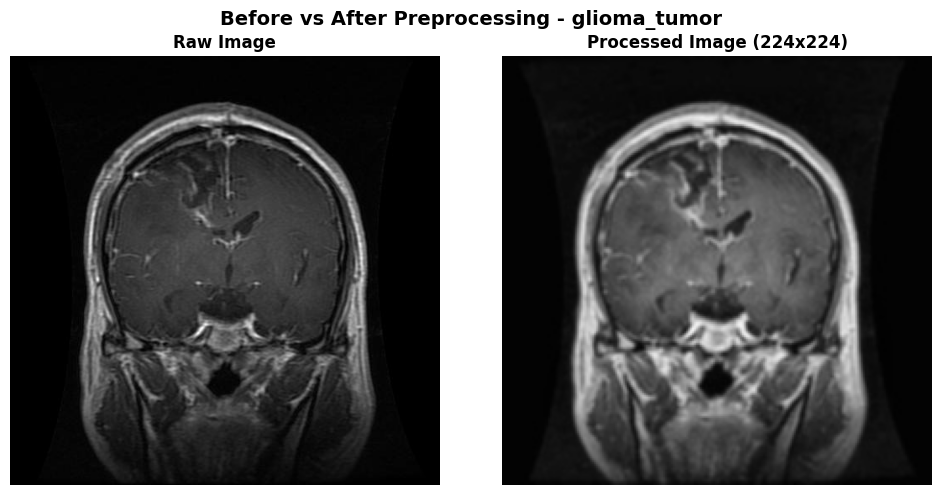

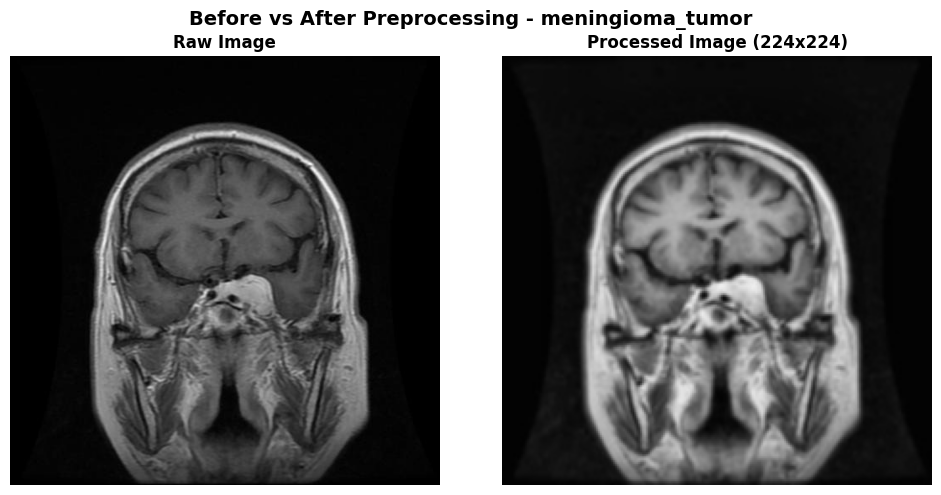

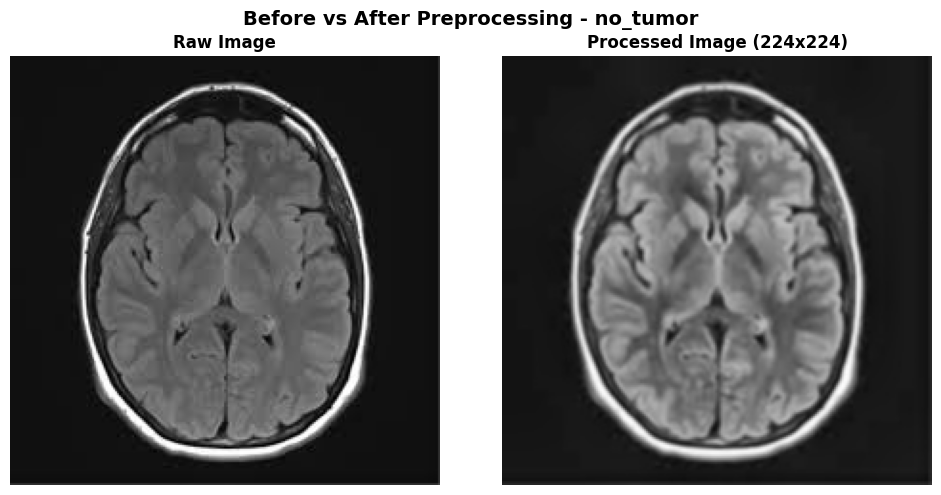

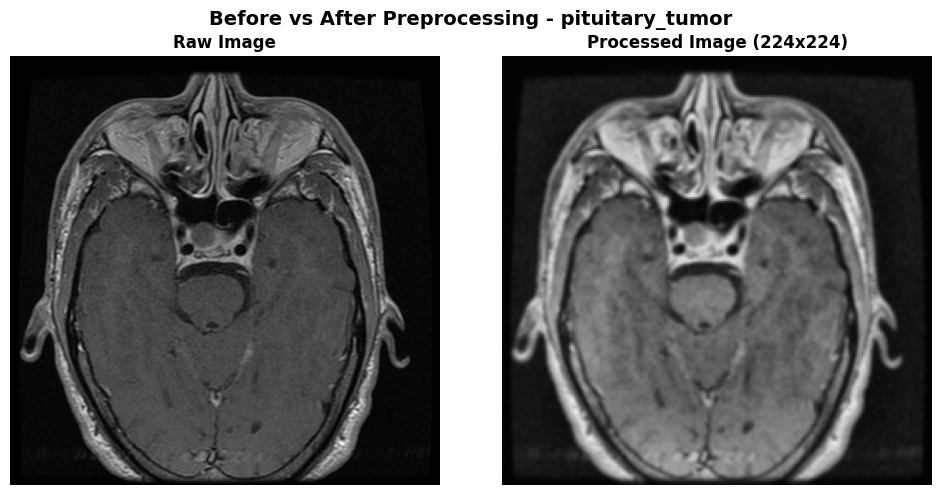

In [13]:
def compare_before_after(class_name='glioma_tumor', num_samples=2):
    """
    Compare raw and processed images side by side
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    fig.suptitle(f'Before vs After Preprocessing - {class_name}',
                 fontsize=14, fontweight='bold')

    raw_class_path = os.path.join(RAW_DATA_PATH, 'Training', class_name)
    processed_class_path = os.path.join(PROCESSED_DATA_PATH, 'Training', class_name)

    if os.path.exists(raw_class_path) and os.path.exists(processed_class_path):
        image_files = [f for f in os.listdir(raw_class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for i in range(min(num_samples, len(image_files))):
            # Raw image
            raw_img_path = os.path.join(raw_class_path, image_files[i])
            raw_img = cv2.imread(raw_img_path)
            raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

            # Processed image
            processed_img_path = os.path.join(processed_class_path, image_files[i])
            processed_img = cv2.imread(processed_img_path)
            processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

            if num_samples == 1:
                axes[0].imshow(raw_img)
                axes[0].set_title('Raw Image', fontsize=12, fontweight='bold')
                axes[0].axis('off')

                axes[1].imshow(processed_img)
                axes[1].set_title(f'Processed Image ({IMG_SIZE}x{IMG_SIZE})',
                                 fontsize=12, fontweight='bold')
                axes[1].axis('off')
            else:
                axes[i, 0].imshow(raw_img)
                axes[i, 0].set_title('Raw Image', fontsize=11, fontweight='bold')
                axes[i, 0].axis('off')

                axes[i, 1].imshow(processed_img)
                axes[i, 1].set_title(f'Processed ({IMG_SIZE}x{IMG_SIZE})',
                                    fontsize=11, fontweight='bold')
                axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Compare for each class
for class_name in TUMOR_CLASSES:
    compare_before_after(class_name, num_samples=1)

In [14]:
def create_summary_report():
    """
    Create a comprehensive summary report of the processed dataset
    """
    print("\n" + "="*70)
    print(" "*20 + "DATASET SUMMARY REPORT")
    print("="*70)

    summary_data = []

    for split in ['Training', 'Testing']:
        split_path = os.path.join(PROCESSED_DATA_PATH, split)

        if os.path.exists(split_path):
            for class_name in TUMOR_CLASSES:
                class_path = os.path.join(split_path, class_name)

                if os.path.exists(class_path):
                    num_images = len([f for f in os.listdir(class_path)
                                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

                    summary_data.append({
                        'Split': split,
                        'Class': class_name,
                        'Images': num_images
                    })

    # Create DataFrame
    df = pd.DataFrame(summary_data)

    # Display summary table
    print("\nProcessed Dataset Distribution:")
    print("-" * 70)
    print(df.to_string(index=False))

    # Calculate totals
    print("\n" + "-" * 70)
    print("\nSummary by Split:")
    print("-" * 70)
    for split in ['Training', 'Testing']:
        split_total = df[df['Split'] == split]['Images'].sum()
        print(f"{split:15s}: {split_total:5d} images")

    print("\nSummary by Class:")
    print("-" * 70)
    for class_name in TUMOR_CLASSES:
        class_total = df[df['Class'] == class_name]['Images'].sum()
        print(f"{class_name:20s}: {class_total:5d} images")

    print("\n" + "="*70)
    print(f"Total Processed Images: {df['Images'].sum()}")
    print("="*70)

    return df

# Generate report
summary_df = create_summary_report()


                    DATASET SUMMARY REPORT

Processed Dataset Distribution:
----------------------------------------------------------------------
   Split            Class  Images
Training     glioma_tumor     826
Training meningioma_tumor     822
Training         no_tumor     395
Training  pituitary_tumor     827
 Testing     glioma_tumor     100
 Testing meningioma_tumor     115
 Testing         no_tumor     105
 Testing  pituitary_tumor      74

----------------------------------------------------------------------

Summary by Split:
----------------------------------------------------------------------
Training       :  2870 images
Testing        :   394 images

Summary by Class:
----------------------------------------------------------------------
glioma_tumor        :   926 images
meningioma_tumor    :   937 images
no_tumor            :   500 images
pituitary_tumor     :   901 images

Total Processed Images: 3264


In [15]:
# Final verification
print("\n" + "="*60)
print("FINAL VERIFICATION")
print("="*60)

verification_passed = True

for split in ['Training', 'Testing']:
    split_path = os.path.join(PROCESSED_DATA_PATH, split)
    print(f"\nChecking {split}...")

    for class_name in TUMOR_CLASSES:
        class_path = os.path.join(split_path, class_name)

        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if len(images) > 0:
                # Check a sample image
                sample_img = cv2.imread(os.path.join(class_path, images[0]))

                if sample_img is not None and sample_img.shape[:2] == (IMG_SIZE, IMG_SIZE):
                    print(f"  ✓ {class_name}: {len(images)} images, size verified")
                else:
                    print(f"  ✗ {class_name}: Size verification failed!")
                    verification_passed = False
            else:
                print(f"  ✗ {class_name}: No images found!")
                verification_passed = False
        else:
            print(f"  ✗ {class_name}: Folder not found!")
            verification_passed = False

if verification_passed:
    print("\n" + "="*60)
    print("✓ ALL VERIFICATIONS PASSED!")
    print("✓ Preprocessed dataset is ready for model training!")
    print("="*60)
else:
    print("\n" + "="*60)
    print("✗ VERIFICATION FAILED - Please check the errors above")
    print("="*60)


FINAL VERIFICATION

Checking Training...
  ✓ glioma_tumor: 826 images, size verified
  ✓ meningioma_tumor: 822 images, size verified
  ✓ no_tumor: 395 images, size verified
  ✓ pituitary_tumor: 827 images, size verified

Checking Testing...
  ✓ glioma_tumor: 100 images, size verified
  ✓ meningioma_tumor: 115 images, size verified
  ✓ no_tumor: 105 images, size verified
  ✓ pituitary_tumor: 74 images, size verified

✓ ALL VERIFICATIONS PASSED!
✓ Preprocessed dataset is ready for model training!
